# Get sMRI / dMRI data and data from BIDS directory

BMED360-2021 `00-dmri-get-data.ipynb`

<a href="https://colab.research.google.com/github/computational-medicine/BMED360-2021/blob/main/Lab3-diffusion-MRI/00-dmri-data.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Learning objectives
- How to download image data from the cloud (Google Drive)
- Converting sMRI and dMRI DICOM data to NIFTI format
- Display sMRI and selected dMRI volumes
- Structure and validation of BIDS (

### For using Colab
**--> (some of) the following libraries must be `pip installed` (i.e. uncommet these among the following pip commands):**

In [1]:
#!pip install gdown

In [2]:
#!pip install pydicom

In [3]:
#!pip install nibabel

In [4]:
#!pip install nilearn

In [5]:
#!pip install dipy

**Download a data file from Google Drive using gdown** (https://github.com/wkentaro/gdown)

In [2]:
import gdown
import shutil
import sys
import os
from os.path import expanduser, join, basename, split
import glob
import shutil
import platform

Check your platform for running this notebook

In [3]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 20.3.0: Thu Jan 21 00:07:06 PST 2021; root:xnu-7195.81.3~1/RELEASE_X86_64)


In [5]:
basedir = './data'
destdir = '%s/Lab3_LG_Prisma_20160218_DICOM' % basedir
niftidir = '%s/Lab3_LG_Prisma_20160218_NIFTI' % basedir

In [6]:
# Download zip-file if ./data does not exist (as when running in Colab)

if os.path.isdir('./data') == False:
    
    ## Download data.zip for Google Drive        
    # OLD https://drive.google.com/file/d/18lUwfxqtWD6BB9WiQKzzSr6RoBcysSqr/view?usp=sharing  
    
    # https://drive.google.com/file/d/1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO/view?usp=sharing
    file_id = '1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = './data.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `data.zip` file
    os.remove(output)
else:
    print(f'./data  exists already!')

Downloading...
From: https://drive.google.com/uc?id=1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO
To: /Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab3-diffusion-MRI/data.zip
1.39GB [01:08, 20.5MB/s]


**Import libraries**

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # this is how we usually import pandas
import numpy as np # this is how we usually import numpy
import sys # only needed to determine Python version number
import pathlib
import subprocess as subp
import matplotlib # only needed to determine Matplotlib version number
import pydicom
import dipy
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
import nilearn

# Enable inline plotting
%matplotlib inline

In [8]:
print('Python version - ' + sys.version)
print('Pandas version - ' + pd.__version__)
print('Numpy version - ' + np.__version__)
print('Matplotlib version - ' + matplotlib.__version__)
print('Seaborn version - ' + sns.__version__)
print('gdown version - ' + gdown.__version__)
print('Pydicom version - ' + pydicom.__version__)
print('Nibabel version - ' + nib.__version__)
print('Nilearn version - ' + nilearn.__version__)
print('DiPy version - ' + dipy.__version__)

Python version - 3.8.0 | packaged by conda-forge | (default, Nov 22 2019, 19:11:19) 
[Clang 9.0.0 (tags/RELEASE_900/final)]
Pandas version - 1.2.4
Numpy version - 1.20.2
Matplotlib version - 3.4.1
Seaborn version - 0.11.1
gdown version - 3.12.2
Pydicom version - 2.1.2
Nibabel version - 3.2.1
Nilearn version - 0.7.1
DiPy version - 1.4.0


In [9]:
try:
    import pydicom as dicom
    print('pydicom package imported successfully!')
except ImportError:
    print ('It seems that you have to install the pydicom package.\n')

pydicom package imported successfully!


## Convert DICOMs to NIFTI

dcm2niix is a designed to convert (neuro)imaging data from the DICOM format to the NIfTI format (https://github.com/rordenlab/dcm2niix)

**If running on Colab, uncomment the following three cells, and comment the two next**

In [15]:
#!curl -fLO https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
#shutil.unpack_archive('dcm2niix_lnx.zip', '.')

In [16]:
#%%bash
#chmod +x ./dcm2niix
#./dcm2niix -h

In [17]:
# DCMCONVERT = ['./dcm2niix']

In [10]:
# Comment this if running in Colab
DCMCONVERT = !which dcm2niix

In [11]:
%%bash 
# Comment the following command if running in Colab:
dcm2niix -h

Chris Rorden's dcm2niiX version v1.0.20210317  Clang11.1.0 x86-64 (64-bit MacOS)
usage: dcm2niix [options] <in_folder>
 Options :
  -1..-9 : gz compression level (1=fastest..9=smallest, default 6)
  -a : adjacent DICOMs (images from same series always in same folder) for faster conversion (n/y, default n)
  -b : BIDS sidecar (y/n/o [o=only: no NIfTI], default y)
   -ba : anonymize BIDS (y/n, default y)
  -c : comment stored in NIfTI aux_file (provide up to 24 characters e.g. '-c first_visit')
  -d : directory search depth. Convert DICOMs in sub-folders of in_folder? (0..9, default 5)
  -e : export as NRRD instead of NIfTI (y/n, default n)
  -f : filename (%a=antenna (coil) name, %b=basename, %c=comments, %d=description, %e=echo number, %f=folder name, %g=accession number, %i=ID of patient, %j=seriesInstanceUID, %k=studyInstanceUID, %m=manufacturer, %n=name of patient, %o=mediaObjectInstanceUID, %p=protocol, %r=instance number, %s=series number, %t=time, %u=acquisition number, %v=vendor

In [12]:
def lab3_dcm2niix(dcm_dir, nii_dir):

    #pathlib.Path(nii_dir).mkdir(parents=True, exist_ok=True)
    cmd = [
        DCMCONVERT[0],
        '-d', '9',
        '-b', 'y',
        '-m', 'n',
        '-s', 'n',
        '-t', 'n',
        '-x', 'n',
        '-w', '1',
        '-z', 'y',
        '-i', 'y',
        '-f', 'lab3_%t_%s_%p', 
        '-o', nii_dir,
        dcm_dir]

    cmd_str = " ".join(cmd)
    output = subp.check_output(cmd)  # import subprocess as subp
    print(f'output: {output} \n')
    
    # Alternatively:
    #print('cmd_str = \n%s\n' % cmd_str)
    #os.system(cmd_str)

In [13]:
mydcm = './data/Lab3_LG_Prisma_20160218_DICOM'
mynii = niftidir

if os.path.isdir(mynii) == False:
    os.makedirs(mynii, exist_ok = False)
    print("Directory '%s' created successfully" % mynii)
    lab3_dcm2niix(mydcm, mynii)
else:
    print("Directory '%s' already exists and will not be overwritten" % mynii)  

Directory './data/Lab3_LG_Prisma_20160218_NIFTI' created successfully
output: b"Chris Rorden's dcm2niiX version v1.0.20210317  Clang11.1.0 x86-64 (64-bit MacOS)\nFound 682 DICOM file(s)\nIgnoring derived image(s) of series 6 ./data/Lab3_LG_Prisma_20160218_DICOM/ep2d_diff_qspace_p2/FOU_160218_BRAIN-GUT_LG.MR.NEVRO_HODE.0006.0001.2016.02.18.14.50.53.808776.94941844.IMA\nIgnoring derived image(s) of series 5 ./data/Lab3_LG_Prisma_20160218_DICOM/ep2d_diff_qspace_p2/FOU_160218_BRAIN-GUT_LG.MR.NEVRO_HODE.0005.0001.2016.02.18.14.50.53.808776.94930587.IMA\nWarning: Assuming mosaics saved in reverse order due to 'sSliceArray.ucImageNumb'\nConvert 192 DICOM as ./data/Lab3_LG_Prisma_20160218_NIFTI/lab3_20160218140906_2_t1_mprage_sag_1mm (256x256x192x1)\nIgnoring derived image(s) of series 7 ./data/Lab3_LG_Prisma_20160218_DICOM/ep2d_diff_qspace_p2/FOU_160218_BRAIN-GUT_LG.MR.NEVRO_HODE.0007.0001.2016.02.18.14.50.53.808776.94945510.IMA\nIgnoring derived image(s) of series 4 ./data/Lab3_LG_Prisma_201

**Remove destdir (`./data/Lab3_LG_Prisma_20160218_DICOM`) after conversion to NIFTI**

In [15]:
if os.path.isdir(mynii) == True:    # Assuming all the DICOM data has been downloaded and converted to NIFTI
    if os.path.isdir(destdir) == True: 
        shutil.rmtree(destdir)

### Inspect NIFTI converted sMRI  and dMRI (viewer from `nibabel`)

In [16]:
files = os.listdir(mynii)
files = sorted([f for f in files if f.endswith('.nii.gz')])
print(f"List contains {len(files)} filenames ends with '.nii.gz' (sMRI, with lower series number, was acquired before dMRI)")
files

List contains 2 filenames ends with '.nii.gz' (sMRI, with lower series number, was acquired before dMRI)


['lab3_20160218140906_2_t1_mprage_sag_1mm.nii.gz',
 'lab3_20160218140906_3_ep2d_diff_qspace_p2.nii.gz']

In [17]:
smri_fn = '%s/%s' % (mynii, files[0])  # files[0] is the sequence (sMRI) with the lowest series number
smri = nib.load(smri_fn)

dmri_fn = '%s/%s' % (mynii, files[1])  # files[1] is the sequence (dMRI) with the higher series number
dmri = nib.load(dmri_fn)

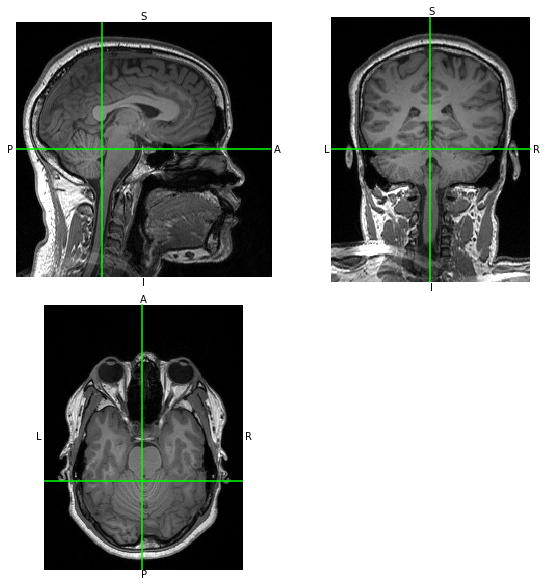

In [18]:
# Viewer from `nibabel`
OrthoSlicer3D(smri.get_fdata(), affine=smri.affine).show()

In [19]:
from nilearn import image
print(image.load_img(dmri_fn).shape)

(100, 100, 60, 129)


**We can retrieve the first and last volumes in the dMRI recording and plot it**

In [20]:
first_dmri = image.index_img(dmri, 0)
last_dmri = image.index_img(dmri, dmri.shape[3]-1)

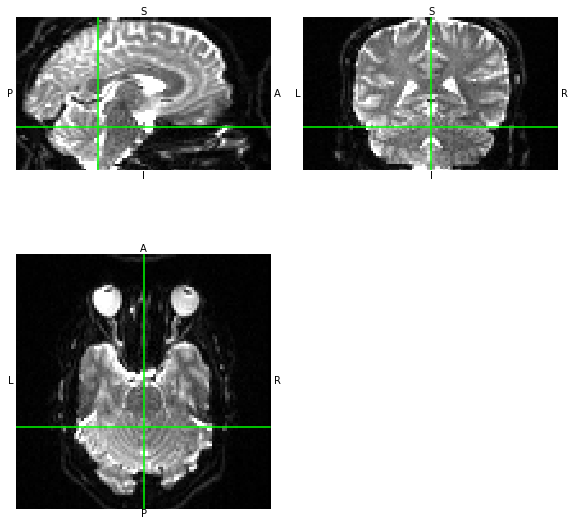

In [21]:
OrthoSlicer3D(first_dmri.get_fdata(), affine=first_dmri.affine).show()

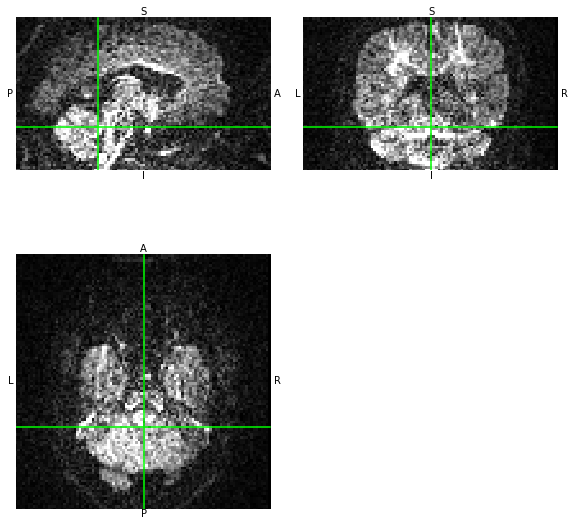

In [22]:
OrthoSlicer3D(last_dmri.get_fdata(), affine=last_dmri.affine).show()